In [50]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from transformers import AdamW, get_linear_schedule_with_warmup
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('always')

input_path = "./data/ranked/"
output_path = "./results/mt/"
if os.path.exists(output_path) == False:
    os.makedirs(output_path)
    os.makefile(output_path + "model.pt")

AttributeError: module 'os' has no attribute 'makefile'

In [ ]:
def clean_text(row):
    text = []
    [text.extend(i.strip().split('।')) for i in row]
    text = [i.strip() for i in text]
    text = list(filter(None, text))
    return text

def clean_dataset():
    train = pd.read_csv(f'{input_path}train.csv')
    test = pd.read_csv(f'{input_path}test.csv')
    val = pd.read_csv(f'{input_path}val.csv')

    # Comment below
    train=train.head(10)
    test=test.head(10)
    val=val.head(10)
    
    # Comment above

    train['ranked-sentences'] = train['ranked-sentences'].apply(eval)
    test['ranked-sentences'] = test['ranked-sentences'].apply(eval)
    val['ranked-sentences'] = val['ranked-sentences'].apply(eval)

    train['segments'] = train['segments'].apply(eval)
    test['segments'] = test['segments'].apply(eval)
    val['segments'] = val['segments'].apply(eval)

    train['ranked-sentences'] = train['ranked-sentences'].apply(clean_text)
    test['ranked-sentences'] = test['ranked-sentences'].apply(clean_text)
    val['ranked-sentences'] = val['ranked-sentences'].apply(clean_text)

    train['facts-and-arguments'] = train['segments'].apply(lambda x: clean_text(x['facts-and-arguments']))
    test['facts-and-arguments'] = test['segments'].apply(lambda x: clean_text(x['facts-and-arguments']))
    val['facts-and-arguments'] = val['segments'].apply(lambda x: clean_text(x['facts-and-arguments']))

    return train, val, test

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.decisions = self.df.decision.map({'dismissed': 0, 'granted': 1})
        self.ranked_sentences = self.df['ranked-sentences']
        self.sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        sample = {}
        lines = self.df.iloc[idx]['facts-and-arguments']
        embeddings = self.sentence_model.encode(
            lines
        )

        labels = [0] * len(lines)
        indices = [lines.index(i) for i in self.ranked_sentences.iloc[idx]]
        for i in indices[:len(labels)//2]:
            labels[i] = 1


        sample['embeddings'] = torch.from_numpy(embeddings)
        sample['bail'] = torch.Tensor([self.decisions.iloc[idx]])
        sample['salience_labels'] = torch.LongTensor(labels)

        return sample 
def custom_collate(batch):

    bails, labels, embs = [], [], []
    for item in batch:
        bails.append(item['bail'])
        labels.append(item['salience_labels'])
        embs.append(item['embeddings'])

    bails = pad_sequence(bails, batch_first=True)
    embs = pad_sequence(embs, batch_first=True)
    labels = pad_sequence(labels, padding_value=-100, batch_first=True)
    return embs, bails.long(), labels.long()


In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self,
                 nhead=1,
                 nlayers=1,
                 use_cls=True,
                #  cls_bail_embed=None,
                 d_model=768):
        super(MultiTaskModel, self).__init__()
        self.saliency_classifier = nn.Linear(d_model, 2)
        self.bail_classifier = nn.Linear(d_model, 2)
        
        ## Use [cls] token or pooling output for bail prediction
        self.use_cls = use_cls
        self.d_model = d_model
        if use_cls:
            self.cls_bail_embed = nn.Embedding(1, self.d_model)
        
        self.encoder_layer = nn.TransformerEncoder(nn.TransformerEncoderLayer(
                                                            d_model=d_model, 
                                                            nhead=nhead,
                                                            batch_first=True), 
                                                      nlayers, 
                                                      norm=None)
  
    def forward(self, x):
        ## x: (batch_size, padded_length, 768)
        batch_size = x.size()[0]
        
        #cls_bail_embed = self.embedding()
        if self.use_cls: 
            ## concatenate [cls] embedding at the start of the sequence
            x = torch.cat([self.cls_bail_embed.weight[0].unsqueeze(0).repeat(batch_size,1,1), x], dim=1)
        x = self.encoder_layer(x)
        if self.use_cls:
            bail_x = x[:,0,:] 
            saliency_x = x[:, 1:, :]
        else:
            bail_x = torch.sum(x, dim=1) 
            saliency_x = x
        bail_logits = self.bail_classifier(bail_x)  ## (batch_size, 2) 
        saliency_logits = self.saliency_classifier(saliency_x) ## (batch_size, padded_length, 2) 
        return bail_logits, saliency_logits

In [ ]:
def train_func_epoch(epoch, model, dataloader, device, optimizer, scheduler, gradient_accumulation_steps=1):

    # Put the model into the training mode
    model.train()

    total_loss = 0

    with tqdm(dataloader, unit="batch", total=len(dataloader)) as single_epoch:

        for step, batch in enumerate(single_epoch):

            single_epoch.set_description(f"Training- Epoch {epoch}")

            embeddings, bail_label, saliency_label = batch 

            ## Load the inputs to the device
            embeddings = embeddings.to(device)
            bail_label = bail_label.to(device)
            saliency_label = saliency_label.to(device)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. 
            bail_logits, saliency_logits = model(embeddings) ## mask

            ## Flaten the logits and label-  logits: (b_s, number_of_sentences, 2) - > (b_s * number_of_sentences, 2)
            saliency_logits = saliency_logits.contiguous().view(-1, saliency_logits.size(-1))
            saliency_label = saliency_label.contiguous().view(-1)

            ## Calculate the final loss
            loss_bail = F.cross_entropy(bail_logits, bail_label.squeeze(1))
            loss_saliency = F.cross_entropy(saliency_logits, saliency_label)

            loss = loss_bail + loss_saliency 

            total_loss += loss.item()
            
            loss.backward()

            if step % gradient_accumulation_steps == 0 or step == len(dataloader) - 1:
                ## Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
                ## torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                
                # Update parameters and the learning rate
                optimizer.step()
                scheduler.step()

            single_epoch.set_postfix(train_loss=total_loss/(step+1))

    return total_loss / len(dataloader)


In [ ]:
def eval_func_epoch(model, dataloader, device, epoch):

    # Put the model into the training mode
    model.eval()

    total_loss = 0

    targets = []
    predictions = []

    with tqdm(dataloader, unit="batch", total=len(dataloader)) as single_epoch:

        for step, batch in enumerate(single_epoch):

            single_epoch.set_description(f"Evaluating- Epoch {epoch}")

            embeddings, bail_label, saliency_label = batch 

            ## Load the inputs to the device
            embeddings = embeddings.to(device)
            bail_label = bail_label.to(device)
            saliency_label = saliency_label.to(device)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. 
            with torch.no_grad():
                bail_logits, saliency_logits = model(embeddings) ## mask

            ## Flaten the logits and label-  logits: (b_s, number_of_sentences, 2) - > (b_s * number_of_sentences, 2)
            saliency_logits = saliency_logits.contiguous().view(-1, saliency_logits.size(-1))
            saliency_label = saliency_label.contiguous().view(-1)

            ## Calculate the final loss
            loss_bail = F.cross_entropy(bail_logits, bail_label.squeeze(1))
            loss_saliency = F.cross_entropy(saliency_logits, saliency_label)

            loss = loss_bail + loss_saliency 
            total_loss += loss.item()
            
            single_epoch.set_postfix(train_loss=total_loss/(step+1))

            # Finding predictions 
            pred_bail = torch.argmax(bail_logits, dim=1).flatten().cpu().numpy()

            predictions.append(pred_bail)
            targets.append(bail_label.squeeze(1).cpu().numpy())

            #if step == 10:
               #break

    targets = np.concatenate(targets, axis=0)
    predictions = np.concatenate(predictions, axis=0)
    
    epoch_validation_loss = total_loss/len(dataloader)

    report = classification_report(targets, predictions, output_dict=True, labels=[0,1])

    tn, fp, fn, tp = confusion_matrix(targets, predictions).ravel()
    if epoch == "TESTING":
        ConfusionMatrixDisplay.from_predictions(targets, predictions)
        plt.savefig(f"{output_path}confusion_matrix.png",dpi=300)
    return epoch_validation_loss, report, tn, fp, fn, tp


Reading CSV files.
Training and Validation datasets ready.
Model ready.

---------------------- Epoch: 1 ---------------------------------- 



/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/m

  0%|          | 0/1 [00:00<?, ?batch/s]

/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py

  0%|          | 0/1 [00:00<?, ?batch/s]

/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu


Epoch: 1 | Training loss: 1.32444429397583 | Validation Loss: 1.3838372230529785

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '1': {'precision': 0.6, 'recall': 1.0, 'f1-score': 0.7499999999999999, 'support': 6.0}, 'accuracy': 0.6, 'macro avg': {'precision': 0.3, 'recall': 0.5, 'f1-score': 0.37499999999999994, 'support': 10.0}, 'weighted avg': {'precision': 0.36, 'recall': 0.6, 'f1-score': 0.4499999999999999, 'support': 10.0}}

TP: 6 | FP: 4 | TN: 0, FN: 0 

----------------------------------------------------------------------------

---------------------- Testing best model (at epoch: 1 )---------------------------------- 



/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/ipywidgets/widgets/widget.py

  0%|          | 0/1 [00:00<?, ?batch/s]


Test loss: 1.189305305480957

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, '1': {'precision': 0.8, 'recall': 1.0, 'f1-score': 0.888888888888889, 'support': 8.0}, 'accuracy': 0.8, 'macro avg': {'precision': 0.4, 'recall': 0.5, 'f1-score': 0.4444444444444445, 'support': 10.0}, 'weighted avg': {'precision': 0.64, 'recall': 0.8, 'f1-score': 0.7111111111111111, 'support': 10.0}}

TP: 8 | FP: 2 | TN: 0, FN: 0 


/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/miniconda3/envs/hldc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

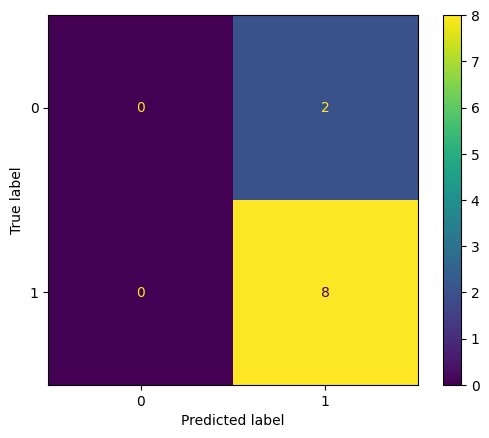

In [ ]:

batch_size = 16
gradient_accumulation_steps = 1
#TODO: Change the number of epochs to 8
epochs = 1
num_warmup_steps = 0
save_model = True 
model_path = output_path+"model.pt" ## Change after every experiment

device =torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
# elif torch.mps.is_available():
#     device = torch.device("mps")

print("Reading CSV files.")
train, val, test = clean_dataset()

train_dataset = Dataset(train)
val_dataset = Dataset(val)
print("Training and Validation datasets ready.")

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate
)

cls_bail_embed = torch.ones(1, 1, 768).to(device) ## embedding size = 768
d_model=768 ## embedding size = 768

model = MultiTaskModel(d_model=768)

model.to(device)
print("Model ready.")
## Load weights

# Uncomment below storing model once

# loaded_state_dict = torch.load(model_path,  map_location=device)
# model.load_state_dict(loaded_state_dict)

#Uncomment above
optimizer = AdamW(model.parameters(), lr=5*1e-5)

num_train_steps = math.ceil(len(train_dataloader)/gradient_accumulation_steps)  * epochs 

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps
)

best_loss = np.inf
best_epoch = 0
for epoch in range(epochs):
    print(f"\n---------------------- Epoch: {epoch+1} ---------------------------------- \n")
    ## Training Loop
    train_loss = train_func_epoch(epoch+1, model, train_dataloader, device, optimizer, scheduler)

    ## Validation loop
    val_loss,report, tn, fp, fn, tp = eval_func_epoch(model, val_dataloader, device, epoch+1)

    print(f"\nEpoch: {epoch+1} | Training loss: {train_loss} | Validation Loss: {val_loss}")
    print()
    print(report)
    print()
    print(f"TP: {tp} | FP: {fp} | TN: {tn}, FN: {fn} ")

    print(f"\n----------------------------------------------------------------------------")

    ## Save the model 
    if (val_loss < best_loss) and (save_model == True):
        torch.save(model.state_dict(), model_path)
        best_loss = val_loss
        best_epoch = epoch+1

## After training get the score on test set 
test_dataset = Dataset(test)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate
)

## Load weights
loaded_state_dict = torch.load(model_path,  map_location=device)
model.load_state_dict(loaded_state_dict)

print(f"\n---------------------- Testing best model (at epoch: {best_epoch} )---------------------------------- \n")
test_loss,report, tn, fp, fn, tp = eval_func_epoch(model, test_dataloader, device, "TESTING")

print(f"\nTest loss: {test_loss}")
print()
print(report)
print()
print(f"TP: {tp} | FP: {fp} | TN: {tn}, FN: {fn} ")





In [ ]:
import json
with open(f"{output_path}results.json","w") as f:
    json.dump(report,f,indent=4) 
